# Predicting Board Game Reviews

The data set contains 80000 board games and their associated review scores. The data was scraped from [BoardGameGeek](http://www.boardgamegeek.com/) and compiled into CSV format by [Sean Beck](https://github.com/ThaWeatherman). The data set is stored in board_games.csv, and can be downloaded [here](https://github.com/ThaWeatherman/scrapers/blob/master/boardgamegeek/games.csv).

Each row represents a single board game, and has descriptive statistics about the board game, as well as review information. Here are some of the interesting columns:

* name: name of the board game.
* playingtime: the playing time (given by the manufacturer).
* minplaytime: the minimum playing time (given by the manufacturer).
* maxplaytime: the maximum playing time (given by the manufacturer).
* minage: the minimum recommended age to play.
* users_rated: the number of users who rated the game.
* average_rating: the average rating given to the game by users. (0-10)
* total_weights: Number of weights given by users. Read more about what BoardGameGeek considers weights [here](https://boardgamegeek.com/wiki/page/Weight).
* average_weight: the average of all the subjective weights (0-5).

We are going to predict average_rating using the other columns.

## Reading in the data

In [94]:
# importing pandas
import pandas as pd

In [95]:
# reading in board_games.csv as a pandas dataframe
board_games = pd.read_csv('board_games.csv')

In [96]:
# printing the first five rows
print(board_games.head())

       id       type                                       name  \
0   12333  boardgame                          Twilight Struggle   
1  120677  boardgame                              Terra Mystica   
2  102794  boardgame                  Caverna: The Cave Farmers   
3   25613  boardgame  Through the Ages: A Story of Civilization   
4    3076  boardgame                                Puerto Rico   

   yearpublished  minplayers  maxplayers  playingtime  minplaytime  \
0         2005.0         2.0         2.0        180.0        180.0   
1         2012.0         2.0         5.0        150.0         60.0   
2         2013.0         1.0         7.0        210.0         30.0   
3         2006.0         2.0         4.0        240.0        240.0   
4         2002.0         2.0         5.0        150.0         90.0   

   maxplaytime  minage  users_rated  average_rating  bayes_average_rating  \
0        180.0    13.0        20113         8.33774               8.22186   
1        150.0    12.0

In [97]:
# printing the dimensions of the data frame
board_games.shape

(81312, 20)

## Cleaning up the data

In [98]:
# dropping all rows with missing values
board_games.dropna(inplace = True)
board_games.shape

(81268, 20)

In [99]:
# filtering the dataframe to only have rows/ games with atleast 1 user rating
board_games = board_games[board_games['users_rated'] > 0]
board_games.shape

(56894, 20)

## Exploring the data

In [100]:
# importing matplotlib.pyplot and seaborn libraries with inline magic command
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

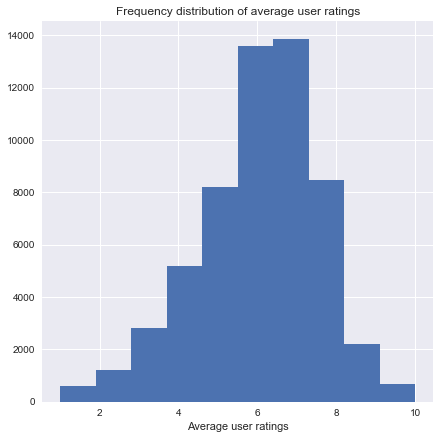

In [101]:
# plotting a histogram of the average user rating values
plt.figure(figsize=(7,7))
plt.hist(board_games['average_rating'])
plt.title('Frequency distribution of average user ratings')
plt.xlabel('Average user ratings')
plt.show()

### Observations

The distribution looks close to normal/ Gaussian. It is slightly negatively skewed/ left tailed.

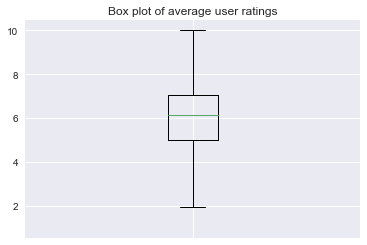

In [102]:
# Box plot of average user ratings
fig, ax = plt.subplots()
plt.boxplot(board_games['average_rating'])
plt.title('Box plot of average user ratings')
ax.set_xticklabels([''])
plt.show()

### Observations

Median is very close to 6. The interquartile range is relatively smaller than upper and lower quartile ranges, suggesting a relatively leptokurtic distribution. 

In [103]:
# computing descriptive stats of average user ratings
board_games['average_rating'].describe()

count    56894.000000
mean         6.016113
std          1.578830
min          1.000000
25%          5.000000
50%          6.150000
75%          7.040000
max         10.000000
Name: average_rating, dtype: float64

### Obervations
Mean is 6, and the median is 6.2. Mean is lower than the median suggesting that there are a considerable number of lower ratings. Standard deviation is 1.6, which is in alignment with our previous observation that the distribution is concentrated around the center.

### Error metric
A good error metric to use for the prediction would be mean squared error or root mean squared error. Considering, a continuous and normally distributed data, we could compare the mean squared error or root mean squared error to variance or standard deviation to see how well the model is performing.

## Cluster analysis

In [104]:
# importing KMeans clustering model from scikit-learn
from sklearn.cluster import KMeans

In [105]:
# initiating, training and predicting KMeans clustering using all numeric columns
kmeans_model = KMeans(n_clusters = 5)
numeric_columns = board_games.iloc[:,3:]
kmeans_model.fit(numeric_columns)
labels = kmeans_model.labels_

In [106]:
# importing numpy library
import numpy as np

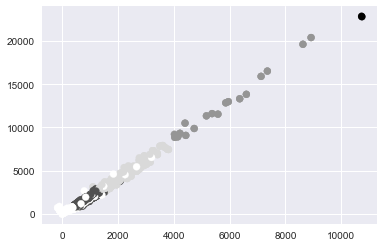

In [107]:
# visualizing clusters with row means and std deviations as x and y axes
game_mean = numeric_columns.apply(np.mean, axis=1)
game_std = numeric_columns.apply(np.std, axis=1)
plt.scatter(game_mean, game_std, c=labels)
plt.show()

### Observations
There is a considerable amount of overlap between 3 clusters which have relatively lower means and std deviations. Consequently, there are fewer rows/ games with higher means and standard deviations suggesting that these games are highly rated and more popular.

## Correlations

In [108]:
# computing the correlations of all numeric columns with average user rating
print(numeric_columns.corr()['average_rating'])

yearpublished           0.108461
minplayers             -0.032701
maxplayers             -0.008335
playingtime             0.048994
minplaytime             0.043985
maxplaytime             0.048994
minage                  0.210049
users_rated             0.112564
average_rating          1.000000
bayes_average_rating    0.231563
total_owners            0.137478
total_traders           0.119452
total_wanters           0.196566
total_wishers           0.171375
total_comments          0.123714
total_weights           0.109691
average_weight          0.351081
Name: average_rating, dtype: float64


### Observations
There is a relatively moderate to strong positive correlation between average weight and rating. This is a bit surprising, given BoardGameGeek's definition of weight, this means that more harder the game is to play the higher it is rated. We do also see some other moderate positive correlations between rating and min age, total wanters and total wishers.

## Modeling and predicting average user ratings

In [109]:
# dropping average rating, bayes average rating columns and columns with weak to no correlations with average rating
# from numeric columns dataframe
numeric_columns.drop(['average_rating','bayes_average_rating','minplayers','maxplayers','playingtime','minplaytime',\
                     'maxplaytime'], axis = 'columns', inplace = True)

In [110]:
# importing linear regression model and mean squared error metric from scikit learn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [111]:
# training and predicting average user ratings using select features/ columns and finding the mean squared error
lr = LinearRegression()
lr.fit(numeric_columns, board_games['average_rating'])
predictions = lr.predict(numeric_columns)
print(mean_squared_error(board_games['average_rating'], predictions))

2.0970561336


### Observations
The error rate is pretty low, so the linear regression model with the selected set of features is able to do a pretty good job on predicting the average user ratings of the games.

## Potential next steps
* Split the data into training and testing sets, and calculate error on the testing set.
* Try algorithms other than linear regression.
* Calculate new predictors based off the existing columns, such as:
    * Player range (maxplayers - minplayers)
    * Playing time range (maxplaytime - minplaytime)
    * Average number of ratings (total_owners / users_rated)
* Scrape the latest data from BoardGameGeek to acquire more data.